# Metadata

```
Course:   DS 5001 
Module:   06 Lab
Topic:    Similarity and Distance Measures
Author:   R.C. Alvarado
```

# Set Up

In [1]:
data_home = "../data"
data_prefix = 'austen-melville'

In [2]:
OHCO_src = ['book_id', 'chap_id']
OHCO = ['book_id']

In [3]:
import pandas as pd
import numpy as np
import re 
from numpy.linalg import norm
from scipy.spatial.distance import pdist

In [4]:
import seaborn as sns
sns.set(style="ticks")

# Data

## Acquire Data

In [5]:
BOW = pd.read_csv(f"{data_home}/output/{data_prefix}-BOW.csv").set_index(OHCO_src+['term_str'])
VOCAB = pd.read_csv(f'{data_home}/output/{data_prefix}-VOCAB2.csv').set_index('term_str')
LIB = pd.read_csv(f'{data_home}/output/{data_prefix}-LIB.csv').set_index('book_id')

In [6]:
LIB.title = LIB.title.apply(lambda x: x[:20])

In [7]:
BOW

n        tf     tfidf
book_id chap_id term_str                       
105     1       1         2  0.000762  0.001548
                15        1  0.000381  0.001056
                16        1  0.000381  0.001171
                1760      1  0.000381  0.001171
                1784      1  0.000381  0.001171
...                      ..       ...       ...
34970   114     ye        1  0.001550  0.001115
                yes       2  0.003101  0.001555
                yet       1  0.001550  0.000253
                young     2  0.003101  0.001075
                your      1  0.001550  0.000365

[716854 rows x 3 columns]

## Create TFIDIF Matrix

This is a document-term matrix with TFIDF weights.

In [368]:
TFIDF = BOW.tfidf.unstack(fill_value=0)

In [369]:
TFIDF.head()

term_str           0         1   10  100  1000  10000  10440  10800  10th  \
book_id chap_id                                                             
105     1        0.0  0.001548  0.0  0.0   0.0    0.0    0.0    0.0   0.0   
        2        0.0  0.000000  0.0  0.0   0.0    0.0    0.0    0.0   0.0   
        3        0.0  0.000000  0.0  0.0   0.0    0.0    0.0    0.0   0.0   
        4        0.0  0.000000  0.0  0.0   0.0    0.0    0.0    0.0   0.0   
        5        0.0  0.000000  0.0  0.0   0.0    0.0    0.0    0.0   0.0   

term_str         118952  ...  zoroaster  zozo  zuma  zur    à  æneas  æniad  \
book_id chap_id          ...                                                  
105     1           0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0    0.0   
        2           0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0    0.0   
        3           0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0    0.0   
        4           0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0    0.0   
        5           0.0  ...        0.0   0.0   0.0  0.0  0.0    0.0    0.0   

term_str         æson  æsops  ł20000  
book_id chap_id                       
105     1         0.0    0.0     0.0  
        2         0.0    0.0     0.0  
        3         0.0    0.0     0.0  
        4         0.0    0.0     0.0  
        5         0.0    0.0     0.0  

[5 rows x 39424 columns]

## Reduce VOCAB 

We use DFIDF to reduce the dimensionality of our `VOCAB` table by an order of magnitude. You may use other reduction measures (such as mean `TFIDF` to what effects this change has on our results.)

In [370]:
sum_method = 'dfidf'
cut_off = VOCAB[sum_method].quantile(.9)

In [371]:
cut_off

51.30964616279745

In [372]:
# SIGS = (VOCAB[sum_method] >= cut_off) & (VOCAB.stop == 0)

In [373]:
pos_list = "NN NNS VB VBD VBG VBN VBP VBZ JJ JJR JJS RB RBR RBS".split() # Open categories with no proper nouns

In [374]:
SIGS = (VOCAB[sum_method] >= cut_off) & (VOCAB.max_pos.isin(pos_list))

In [375]:
VOCAB_SHORT = VOCAB.loc[SIGS]

In [376]:
VOCAB_SHORT

,term_rank,n,n_chars,p,i,max_pos,n_pos,stop,stem_porter,stem_snowball,...,max_pos_group,term_rank2,zipf_k,zipf_k2,df,idf,tfidf_mean,tfidf_max,dfidf,dfidf2
term_str,,,,,,,,,,,,,,,,,,,,,
had,21,13266,3,0.006687,7.224336,VBD,14,1,had,had,...,VB,21,278586,278586,1017.0,0.066031,0.000424,0.001861,67.153272,0.056717
is,22,13123,2,0.006615,7.239971,VBZ,14,1,is,is,...,VB,22,288706,288706,1049.0,0.052576,0.000402,0.004381,55.152449,0.046581
have,27,10099,4,0.005091,7.617857,VB,8,1,have,have,...,VB,27,272673,272673,1041.0,0.055901,0.000287,0.007986,58.192913,0.049149
were,35,7928,4,0.003997,7.967040,VBD,13,1,were,were,...,VB,35,277480,277480,1015.0,0.066886,0.000292,0.001167,67.888945,0.057339
very,42,6150,4,0.003100,8.333411,RB,9,1,veri,veri,...,RB,42,258300,258300,916.0,0.111456,0.000418,0.055728,102.093906,0.086228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
appearances,4678,33,11,0.000017,15.875387,NNS,6,0,appear,appear,...,NN,745,154374,24585,33.0,1.554838,0.000861,0.002492,51.309646,0.043336
relish,4718,33,6,0.000017,15.875387,NN,4,0,relish,relish,...,NN,745,155694,24585,33.0,1.554838,0.001000,0.003329,51.309646,0.043336
elbow,4732,33,5,0.000017,15.875387,NN,5,0,elbow,elbow,...,NN,745,156156,24585,33.0,1.554838,0.000868,0.002723,51.309646,0.043336


In [377]:
TFIDF = TFIDF[VOCAB_SHORT.index]

In [378]:
TFIDF

term_str              had        is      have      were      very      been  \
book_id chap_id                                                               
105     1        0.001861  0.000100  0.000256  0.000331  0.000679  0.000885   
        2        0.000937  0.000107  0.000396  0.000203  0.000678  0.000753   
        3        0.000442  0.000482  0.000453  0.000118  0.000864  0.000327   
        4        0.001793  0.000000  0.000372  0.000222  0.000309  0.001235   
        5        0.000656  0.000158  0.000740  0.000483  0.000637  0.000531   
...                   ...       ...       ...       ...       ...       ...   
34970   110      0.000100  0.000320  0.000085  0.000203  0.000169  0.000141   
        111      0.000183  0.000437  0.000155  0.000185  0.000000  0.000171   
        112      0.000200  0.000080  0.000000  0.000304  0.000169  0.000000   
        113      0.000348  0.000692  0.000000  0.000704  0.000000  0.000489   
        114      0.000102  0.000326  0.000173  0.000207  0.000000  0.000288   

term_str              are       now      more      said  ...  subtle  wheel  \
book_id chap_id                                          ...                  
105     1        0.000000  0.000124  0.000113  0.000000  ...     0.0    0.0   
        2        0.000000  0.000000  0.000526  0.000183  ...     0.0    0.0   
        3        0.000401  0.000023  0.000288  0.000444  ...     0.0    0.0   
        4        0.000000  0.000072  0.000288  0.000000  ...     0.0    0.0   
        5        0.000200  0.000118  0.000246  0.000271  ...     0.0    0.0   
...                   ...       ...       ...       ...  ...     ...    ...   
34970   110      0.000288  0.000396  0.000338  0.000274  ...     0.0    0.0   
        111      0.000350  0.000782  0.000000  0.000166  ...     0.0    0.0   
        112      0.000000  0.000099  0.000225  0.000000  ...     0.0    0.0   
        113      0.000000  0.001029  0.000000  0.000000  ...     0.0    0.0   
        114      0.000294  0.000404  0.000115  0.000000  ...     0.0    0.0   

term_str         successful  outlandish    valued  appearances  relish  elbow  \
book_id chap_id                                                                 
105     1               0.0         0.0  0.000592     0.000000     0.0    0.0   
        2               0.0         0.0  0.000000     0.000000     0.0    0.0   
        3               0.0         0.0  0.000000     0.000000     0.0    0.0   
        4               0.0         0.0  0.000000     0.000861     0.0    0.0   
        5               0.0         0.0  0.000000     0.000000     0.0    0.0   
...                     ...         ...       ...          ...     ...    ...   
34970   110             0.0         0.0  0.000000     0.000000     0.0    0.0   
        111             0.0         0.0  0.000000     0.000000     0.0    0.0   
        112             0.0         0.0  0.000000     0.000000     0.0    0.0   
        113             0.0         0.0  0.000000     0.000000     0.0    0.0   
        114             0.0         0.0  0.000000     0.000000     0.0    0.0   

term_str         avail  traced  
book_id chap_id                 
105     1          0.0     0.0  
        2          0.0     0.0  
        3          0.0     0.0  
        4          0.0     0.0  
        5          0.0     0.0  
...                ...     ...  
34970   110        0.0     0.0  
        111        0.0     0.0  
        112        0.0     0.0  
        113        0.0     0.0  
        114        0.0     0.0  

[1184 rows x 3728 columns]

## Collapse Bags

We want to work with larger bags in this notebook, in order to better visualize our resulting clusters. Note that this is different than
computing TFIDF with larger bags!

In [379]:
TFIDF = TFIDF.groupby(OHCO).mean()

In [380]:
TFIDF

term_str,had,is,have,were,very,been,are,now,more,said,...,subtle,wheel,successful,outlandish,valued,appearances,relish,elbow,avail,traced
book_id,,,,,,,,,,,,,,,,,,,,,
105,0.000988,0.000229,0.000374,0.000338,0.000608,0.000582,0.000151,0.000118,0.000250,0.000331,...,0.000000,0.000000,0.000027,0.000000,0.000086,0.000076,0.000000,0.000011,0.000023,0.000000
121,0.000596,0.000366,0.000346,0.000277,0.000557,0.000351,0.000288,0.000133,0.000193,0.000419,...,0.000000,0.000000,0.000052,0.000000,0.000063,0.000070,0.000013,0.000024,0.000018,0.000017
141,0.000678,0.000315,0.000414,0.000289,0.000524,0.000429,0.000215,0.000141,0.000250,0.000438,...,0.000000,0.000012,0.000039,0.000000,0.000038,0.000000,0.000008,0.000024,0.000011,0.000016
158,0.000692,0.000379,0.000447,0.000249,0.000832,0.000452,0.000243,0.000126,0.000219,0.000503,...,0.000000,0.000000,0.000030,0.000000,0.000045,0.000032,0.000009,0.000012,0.000021,0.000000
161,0.000544,0.000332,0.000359,0.000259,0.000462,0.000321,0.000190,0.000125,0.000258,0.000611,...,0.000000,0.000000,0.000015,0.000000,0.000080,0.000022,0.000020,0.000000,0.000030,0.000011
946,0.000253,0.000664,0.000603,0.000124,0.000379,0.000327,0.000247,0.000124,0.000216,0.000087,...,0.000000,0.000000,0.000000,0.000000,0.000056,0.000056,0.000000,0.000000,0.000065,0.000000
1212,0.000417,0.000446,0.000462,0.000238,0.000300,0.000265,0.000390,0.000161,0.000140,0.000668,...,0.000000,0.000000,0.000000,0.000054,0.000013,0.000000,0.000062,0.000000,0.000022,0.000000
1342,0.000640,0.000373,0.000388,0.000313,0.000461,0.000379,0.000269,0.000108,0.000201,0.000602,...,0.000000,0.000000,0.000045,0.000000,0.000067,0.000015,0.000000,0.000000,0.000015,0.000016
1900,0.000435,0.000238,0.000204,0.000387,0.000139,0.000241,0.000232,0.000093,0.000142,0.000084,...,0.000000,0.000015,0.000009,0.000091,0.000009,0.000048,0.000061,0.000027,0.000121,0.000046


## Reduced BOW

In [381]:
BOW_REDUCED = TFIDF.stack().to_frame('tfidf')

## Create a `DOC` table

We do this in case we are using multikey indexes for our docs. For example, if we were clusting chapters, we would 
want to flatten `['book_id', 'chap_id']` into a single column index. This will help us below when we create a table of pairs.

In the case of books as docs, this is just the `LIB` table.

In [382]:
TFIDF

term_str,had,is,have,were,very,been,are,now,more,said,...,subtle,wheel,successful,outlandish,valued,appearances,relish,elbow,avail,traced
book_id,,,,,,,,,,,,,,,,,,,,,
105,0.000988,0.000229,0.000374,0.000338,0.000608,0.000582,0.000151,0.000118,0.000250,0.000331,...,0.000000,0.000000,0.000027,0.000000,0.000086,0.000076,0.000000,0.000011,0.000023,0.000000
121,0.000596,0.000366,0.000346,0.000277,0.000557,0.000351,0.000288,0.000133,0.000193,0.000419,...,0.000000,0.000000,0.000052,0.000000,0.000063,0.000070,0.000013,0.000024,0.000018,0.000017
141,0.000678,0.000315,0.000414,0.000289,0.000524,0.000429,0.000215,0.000141,0.000250,0.000438,...,0.000000,0.000012,0.000039,0.000000,0.000038,0.000000,0.000008,0.000024,0.000011,0.000016
158,0.000692,0.000379,0.000447,0.000249,0.000832,0.000452,0.000243,0.000126,0.000219,0.000503,...,0.000000,0.000000,0.000030,0.000000,0.000045,0.000032,0.000009,0.000012,0.000021,0.000000
161,0.000544,0.000332,0.000359,0.000259,0.000462,0.000321,0.000190,0.000125,0.000258,0.000611,...,0.000000,0.000000,0.000015,0.000000,0.000080,0.000022,0.000020,0.000000,0.000030,0.000011
946,0.000253,0.000664,0.000603,0.000124,0.000379,0.000327,0.000247,0.000124,0.000216,0.000087,...,0.000000,0.000000,0.000000,0.000000,0.000056,0.000056,0.000000,0.000000,0.000065,0.000000
1212,0.000417,0.000446,0.000462,0.000238,0.000300,0.000265,0.000390,0.000161,0.000140,0.000668,...,0.000000,0.000000,0.000000,0.000054,0.000013,0.000000,0.000062,0.000000,0.000022,0.000000
1342,0.000640,0.000373,0.000388,0.000313,0.000461,0.000379,0.000269,0.000108,0.000201,0.000602,...,0.000000,0.000000,0.000045,0.000000,0.000067,0.000015,0.000000,0.000000,0.000015,0.000016
1900,0.000435,0.000238,0.000204,0.000387,0.000139,0.000241,0.000232,0.000093,0.000142,0.000084,...,0.000000,0.000015,0.000009,0.000091,0.000009,0.000048,0.000061,0.000027,0.000121,0.000046


In [383]:
DOC = pd.DataFrame(index=TFIDF.index)

In [384]:
DOC.head()

""
book_id
105
121
141
158
161


## Add a meaningful Title to DOC index

This will be useful for labeling our visualizations.

In [385]:
try:
    DOC = DOC.join(LIB[['author','title']]) 
except ValueError:
    pass
DOC['label'] = DOC.apply(lambda x: f"{x.author.split(',')[0]} {x.name}: {x.title}", 1) #DOC.author + ': ' + DOC['title']

In [386]:
DOC

,author,title,label
book_id,,,
105,"AUSTEN, JANE",PERSUASION,AUSTEN 105: PERSUASION
121,"AUSTEN, JANE",NORTHANGER ABBEY,AUSTEN 121: NORTHANGER ABBEY
141,"AUSTEN, JANE",MANSFIELD PARK,AUSTEN 141: MANSFIELD PARK
158,"AUSTEN, JANE",EMMA,AUSTEN 158: EMMA
161,"AUSTEN, JANE",SENSE AND SENSIBILIT,AUSTEN 161: SENSE AND SENSIBILIT
946,"AUSTEN, JANE",LADY SUSAN,AUSTEN 946: LADY SUSAN
1212,"AUSTEN, JANE",LOVE AND FREINDSHIP,AUSTEN 1212: LOVE AND FREINDSHIP
1342,"AUSTEN, JANE",PRIDE AND PREJUDICE,AUSTEN 1342: PRIDE AND PREJUDICE
1900,"MELVILLE, HERMAN",TYPEE A ROMANCE OF T,MELVILLE 1900: TYPEE A ROMANCE OF T


## Create Normalized Tables

In [387]:
L0 = TFIDF.astype('bool').astype('int') # Binary (Pseudo L)
L1 = TFIDF.apply(lambda x: x / x.sum(), 1) # Manhattan (Probabilistic)
L2 = TFIDF.apply(lambda x: x / norm(x), 1) # Pythagorean

In [388]:
# L1.sum(1)

In [389]:
# ((L2.T)**2).sum()

In [390]:
BOW_REDUCED['binary'] = L0.stack()
BOW_REDUCED['tfidf_l1'] = L1.stack()
BOW_REDUCED['tfidf_l2'] = L2.stack()

In [391]:
BOW_REDUCED

tfidf  binary  tfidf_l1  tfidf_l2
book_id term_str                                         
105     had          0.000988       1  0.004027  0.153528
        is           0.000229       1  0.000932  0.035548
        have         0.000374       1  0.001522  0.058029
        were         0.000338       1  0.001378  0.052557
        very         0.000608       1  0.002477  0.094437
...                       ...     ...       ...       ...
34970   appearances  0.000016       1  0.000062  0.002150
        relish       0.000003       1  0.000013  0.000444
        elbow        0.000039       1  0.000148  0.005108
        avail        0.000013       1  0.000052  0.001786
        traced       0.000057       1  0.000220  0.007596

[67104 rows x 4 columns]

## Create Doc Pair Table

Create a table to store our results.

Note that `pist()` is a "distance matrix computation from a collection of raw observation vectors stored in a rectangular array".

In [392]:
PAIRS = TFIDF.T.corr().stack().to_frame('correl')
PAIRS.index.names = ['doc_a','doc_b']
PAIRS = PAIRS.query("doc_a > doc_b")

In [393]:
PAIRS

correl
doc_a doc_b          
121   105    0.705014
141   105    0.795926
      121    0.741333
158   105    0.794257
      121    0.735381
...               ...
34970 10712  0.075253
      13720  0.276034
      13721  0.388849
      15422  0.207519
      21816  0.054523

[153 rows x 1 columns]

In [394]:
# Alternate method to generate pairs
# PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([DOC.index.tolist(), DOC.index.tolist()])).reset_index()
# PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])
# PAIRS.index.names = ['doc_a', 'doc_b']

In [395]:
PAIRS.shape

(153, 1)

In [396]:
PAIRS.head()

correl
doc_a doc_b          
121   105    0.705014
141   105    0.795926
      121    0.741333
158   105    0.794257
      121    0.735381

## Compute Distances

In [397]:
combos  = [
    (TFIDF, 'cityblock', 'cityblock'),
    (TFIDF, 'euclidean', 'euclidean'),
    (TFIDF, 'cosine', 'cosine'),
    (L0, 'jaccard', 'jaccard'),
    (L1, 'jensenshannon', 'js'),
]

In [398]:
TFIDF

term_str,had,is,have,were,very,been,are,now,more,said,...,subtle,wheel,successful,outlandish,valued,appearances,relish,elbow,avail,traced
book_id,,,,,,,,,,,,,,,,,,,,,
105,0.000988,0.000229,0.000374,0.000338,0.000608,0.000582,0.000151,0.000118,0.000250,0.000331,...,0.000000,0.000000,0.000027,0.000000,0.000086,0.000076,0.000000,0.000011,0.000023,0.000000
121,0.000596,0.000366,0.000346,0.000277,0.000557,0.000351,0.000288,0.000133,0.000193,0.000419,...,0.000000,0.000000,0.000052,0.000000,0.000063,0.000070,0.000013,0.000024,0.000018,0.000017
141,0.000678,0.000315,0.000414,0.000289,0.000524,0.000429,0.000215,0.000141,0.000250,0.000438,...,0.000000,0.000012,0.000039,0.000000,0.000038,0.000000,0.000008,0.000024,0.000011,0.000016
158,0.000692,0.000379,0.000447,0.000249,0.000832,0.000452,0.000243,0.000126,0.000219,0.000503,...,0.000000,0.000000,0.000030,0.000000,0.000045,0.000032,0.000009,0.000012,0.000021,0.000000
161,0.000544,0.000332,0.000359,0.000259,0.000462,0.000321,0.000190,0.000125,0.000258,0.000611,...,0.000000,0.000000,0.000015,0.000000,0.000080,0.000022,0.000020,0.000000,0.000030,0.000011
946,0.000253,0.000664,0.000603,0.000124,0.000379,0.000327,0.000247,0.000124,0.000216,0.000087,...,0.000000,0.000000,0.000000,0.000000,0.000056,0.000056,0.000000,0.000000,0.000065,0.000000
1212,0.000417,0.000446,0.000462,0.000238,0.000300,0.000265,0.000390,0.000161,0.000140,0.000668,...,0.000000,0.000000,0.000000,0.000054,0.000013,0.000000,0.000062,0.000000,0.000022,0.000000
1342,0.000640,0.000373,0.000388,0.000313,0.000461,0.000379,0.000269,0.000108,0.000201,0.000602,...,0.000000,0.000000,0.000045,0.000000,0.000067,0.000015,0.000000,0.000000,0.000015,0.000016
1900,0.000435,0.000238,0.000204,0.000387,0.000139,0.000241,0.000232,0.000093,0.000142,0.000084,...,0.000000,0.000015,0.000009,0.000091,0.000009,0.000048,0.000061,0.000027,0.000121,0.000046


In [399]:
for X, metric, label in combos:
    PAIRS[label] = pdist(X, metric)

## Compare Distributions

In [400]:
PAIRS.head(20).style.background_gradient(cmap='YlGnBu', high=.5)

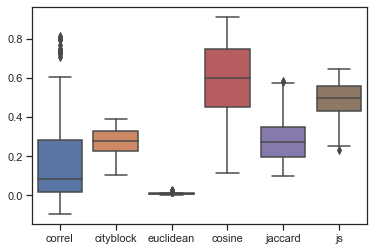

In [401]:
sns.boxplot(data=PAIRS);

In [402]:
PAIRS.describe().T.sort_values('std')

,count,mean,std,min,25%,50%,75%,max
euclidean,153.0,0.010187,0.006027,0.003110,0.006896,0.007954,0.010124,0.028196
cityblock,153.0,0.272122,0.065723,0.105047,0.227442,0.276429,0.327887,0.391921
js,153.0,0.480876,0.098119,0.230752,0.428874,0.494712,0.559522,0.642813
jaccard,153.0,0.287576,0.116429,0.101035,0.194934,0.273819,0.347790,0.586510
cosine,153.0,0.577588,0.207331,0.116280,0.453834,0.601807,0.748953,0.912317
correl,153.0,0.188229,0.248050,-0.096865,0.017756,0.085089,0.283399,0.813713


In [403]:
PAIRS.corr().style.background_gradient(cmap='YlGnBu', axis=None)

,correl,cityblock,euclidean,cosine,jaccard,js
correl,1.000000,-0.294407,-0.202226,-0.302116,-0.106184,-0.276455
cityblock,-0.294407,1.000000,0.621817,0.940383,0.517295,0.989129
euclidean,-0.202226,0.621817,1.000000,0.792930,0.017327,0.552022
cosine,-0.302116,0.940383,0.792930,1.000000,0.274095,0.899167
jaccard,-0.106184,0.517295,0.017327,0.274095,1.000000,0.609320
js,-0.276455,0.989129,0.552022,0.899167,0.609320,1.000000


In [404]:
if PAIRS.shape[0] > 1000:
    SAMPLE = PAIRS.sample(1000)
else:
    SAMPLE = PAIRS

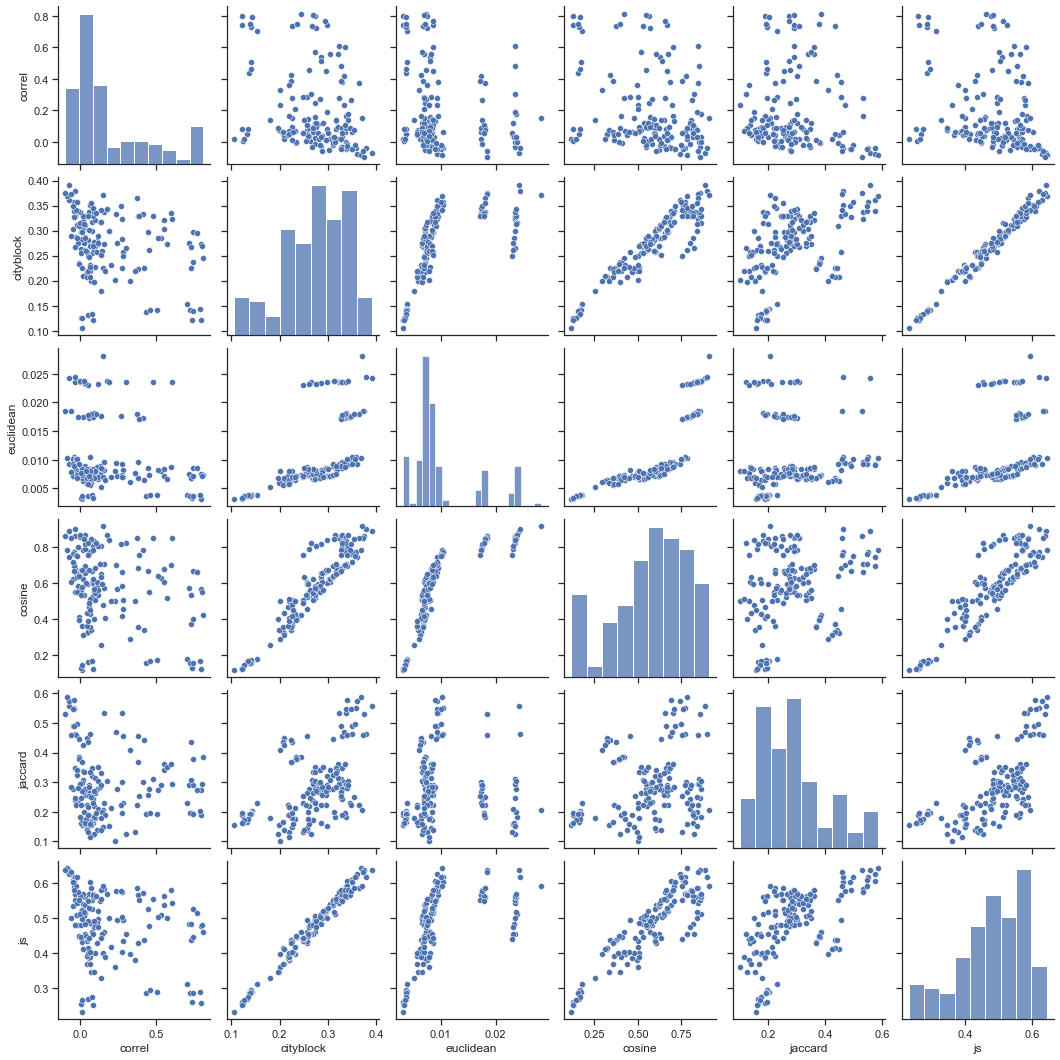

In [405]:
sns.pairplot(SAMPLE);

# Create Clusters

## Hiearchical

In [406]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

In [407]:
def hca(sims, linkage_method='complete', color_thresh=.3, figsize=(10, 10)):
    tree = sch.linkage(sims, method=linkage_method)
    labels = DOC.label.values
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)

<Figure size 432x288 with 0 Axes>

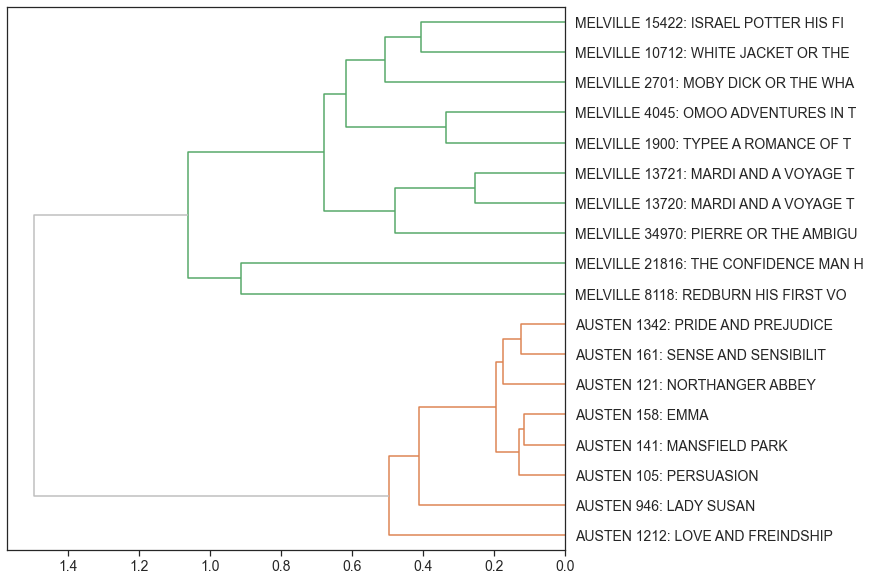

In [408]:
hca(PAIRS.cosine, linkage_method='ward', color_thresh=1.2)

<Figure size 432x288 with 0 Axes>

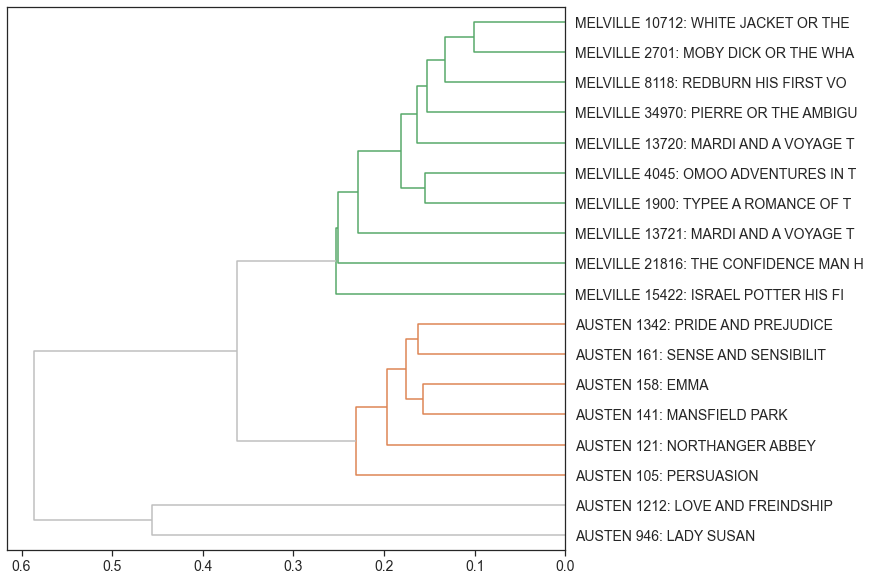

In [409]:
hca(PAIRS.jaccard, color_thresh=.3);

<Figure size 432x288 with 0 Axes>

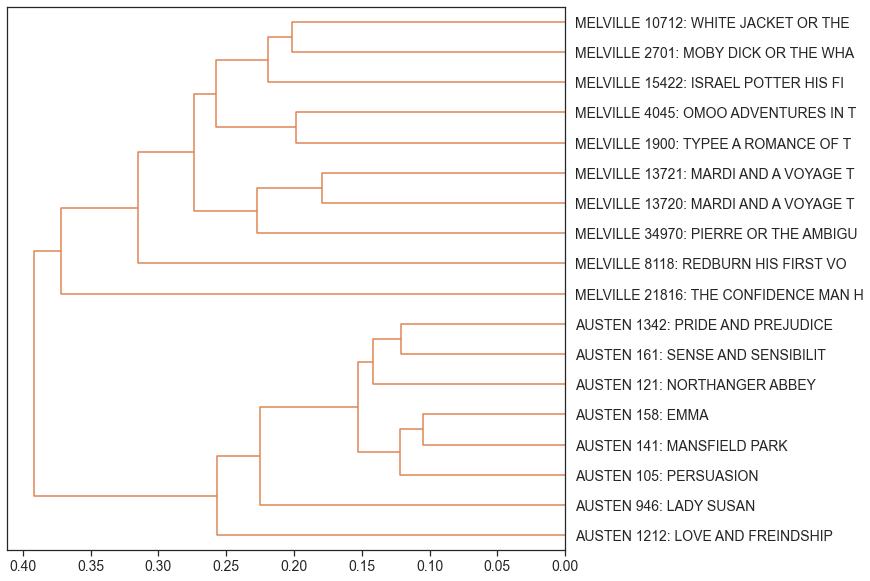

In [410]:
hca(PAIRS.cityblock, color_thresh=2200);

<Figure size 432x288 with 0 Axes>

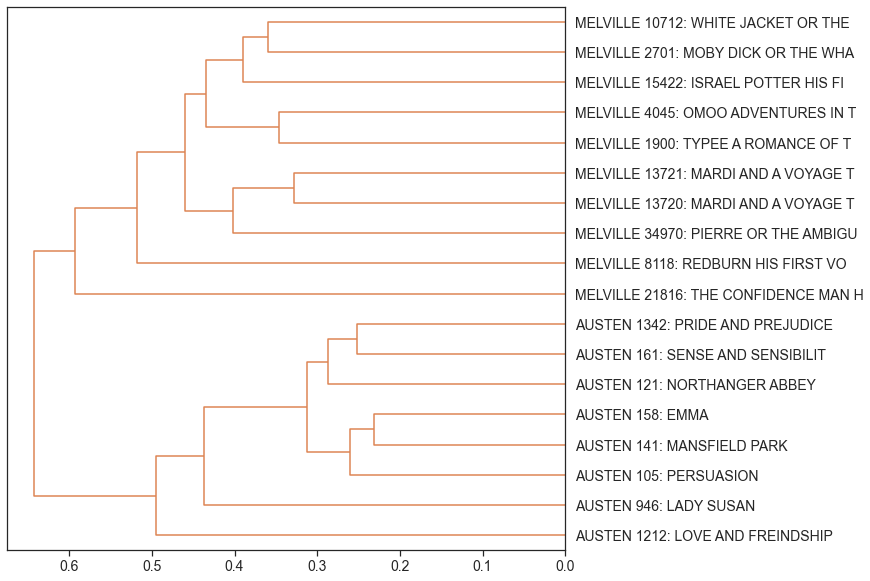

In [411]:
hca(PAIRS.js, color_thresh=.65);

<Figure size 432x288 with 0 Axes>

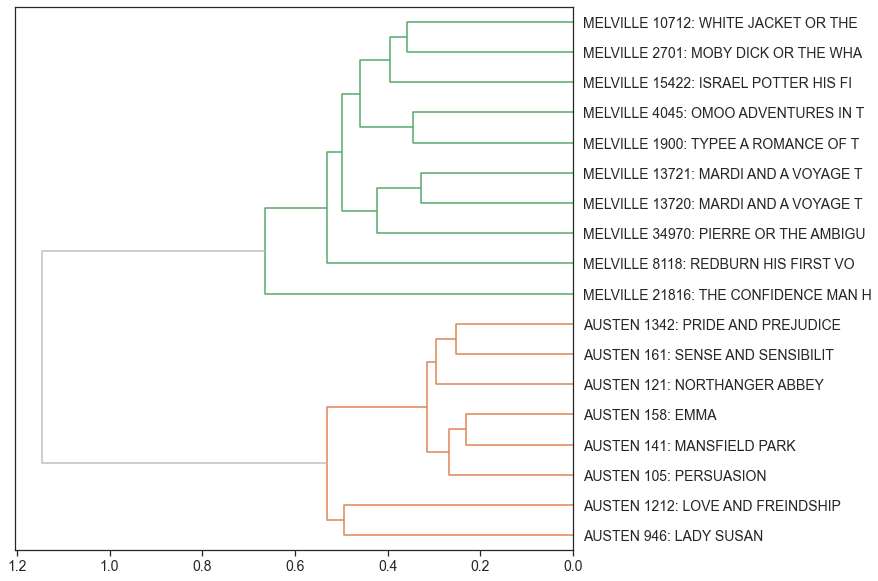

In [412]:
hca(PAIRS.js, linkage_method='ward', color_thresh=.7);

## K-Means

K-Means *only* uses Euclidean distance. Why?

* The K-Means procedure does not explicitly use pairwise distances between data points. 
* Instead, it repeatedly assigns points to the closest centroid thereby using Euclidean distance from data points to a centroid. 
* However, K-Means is *implicitly* based on pairwise Euclidean distances between data points, because the sum of squared deviations from centroid is equal to the sum of pairwise squared Euclidean distances divided by the number of points. 
* The term "centroid" is itself from Euclidean geometry. It is multivariate mean in Euclidean space. Euclidean space is about euclidean distances. Non-Euclidean distances will generally not span Euclidean space. That's why K-Means is for Euclidean distances only.

See the [Cross Validated](https://stats.stackexchange.com/questions/81481/why-does-k-means-clustering-algorithm-use-only-euclidean-distance-metric) post on this.

In [413]:
from sklearn.cluster import KMeans

In [414]:
n_clusters = 6

In [415]:
DOC['y_raw'] = KMeans(n_clusters).fit_predict(TFIDF)
DOC['y_L0'] = KMeans(n_clusters).fit_predict(L0)
DOC['y_L1'] = KMeans(n_clusters).fit_predict(L1)
DOC['y_L2'] = KMeans(n_clusters).fit_predict(L2)

In [416]:
DOC.iloc[:,1:].sort_values('label').style.background_gradient(cmap='YlGn')

,title,label,y_raw,y_L0,y_L1,y_L2
book_id,,,,,,
105,PERSUASION,AUSTEN 105: PERSUASION,0,2,0,0
1212,LOVE AND FREINDSHIP,AUSTEN 1212: LOVE AND FREINDSHIP,0,5,0,0
121,NORTHANGER ABBEY,AUSTEN 121: NORTHANGER ABBEY,0,2,0,0
1342,PRIDE AND PREJUDICE,AUSTEN 1342: PRIDE AND PREJUDICE,0,2,0,0
141,MANSFIELD PARK,AUSTEN 141: MANSFIELD PARK,0,2,0,0
158,EMMA,AUSTEN 158: EMMA,0,2,0,0
161,SENSE AND SENSIBILIT,AUSTEN 161: SENSE AND SENSIBILIT,0,2,0,0
946,LADY SUSAN,AUSTEN 946: LADY SUSAN,0,0,5,0
10712,WHITE JACKET OR THE,MELVILLE 10712: WHITE JACKET OR THE,3,1,3,1


# Save Work

In [417]:
# TFIDF.to_csv('{}/{}-TFIDF_book_reduced.csv'.format(data_out, data_prefix))
# CORR.to_csv('{}/{}-DOCPAIRS.csv'.format(data_out, data_prefix))
# DOC.to_csv('{}/{}-DOC.csv'.format(data_out, data_prefix))
# VOCAB_SHORT.to_csv(f"{data_out}/{data_prefix}-VOCAB_SHORT.csv")